In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
sys.path.append("../")
import matplotlib.pyplot as plt
import time
import h5py

/home/ekellbuch/miniconda2/envs/volcaim/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import preprocess_blockSVD as pre_svd
import trefide as tfd
import spatial_filtering as sp_filters
#from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#import scipy as sp
import tools as tools
import cvxpy as cp
import caiman as cm


In [3]:
m_orig1 = cm.load_movie_chain(['lab/scan1_slice1_block1_crop_long'+'_rig.tif'])
m_orig2 = cm.load_movie_chain(['lab/scan1_slice2_block1_crop_long'+'_rig.tif'])
m_orig3 = cm.load_movie_chain(['lab/scan1_slice3_block1_crop_long'+'_rig.tif'])


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


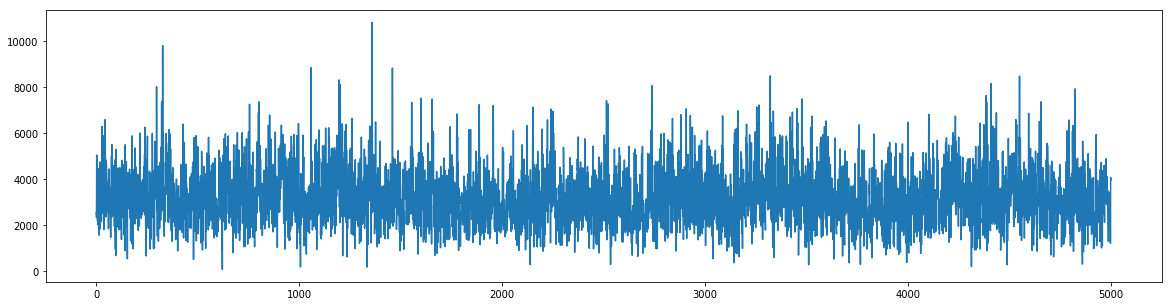

In [4]:
plt.figure(figsize=(20,5))
plt.plot(m_orig1[:,60,50])
m_orig = np.concatenate([m_orig1[:,5:-5,5:-5],
                     m_orig2[:,5:-5,5:-5],
                     m_orig3[:,5:-5,5:-5]],axis=1)

In [ ]:
#m_orig1[:,5:85,5:85].play(magnification=3)

In [5]:
def pre_wf(images_):
    images_ = np.asarray(images_)
    dims = images_.shape
    images_r = images_.reshape((np.prod(dims[:2]),dims[2]),order='F')
    if False:
        # run WF on Y
        images_wf,_ = sp_filters.spatial_filter_image(images_r.reshape(dims,order='F'))
        # cm.movie(images_wf).transpose([2,0,1]).play(magnification=10)
        images_wf = images_wf.reshape((np.prod(dims[:2]),dims[2]),order='F')
    else:
        images_wf = images_r.copy()
    return images_wf

In [6]:
images_1 = m_orig1[1000:3000,5:85,5:85].transpose([1,2,0])
images_2 = m_orig2[1000:3000,5:85,5:85].transpose([1,2,0])
images_3 = m_orig3[1000:3000,5:85,5:85].transpose([1,2,0])

images_wf1 = pre_wf(images_1)
images_wf2 = pre_wf(images_2)
images_wf3 = pre_wf(images_3)

In [7]:
def noise_norm(images_wf,dims=None):
    # subtract off the mean,
    mean_px = images_wf.mean(1,keepdims=True)
    images_wf = images_wf - mean_px
    if True:
        # compute noise level
        # and normalize each pixel to have unit noise level
        noise_level = sp_filters.noise_estimator(images_wf[:,:],range_ff=[0.25,0.5])
        image_= images_wf/noise_level[:,np.newaxis]
        # confirm noise variance =1 in each pixel
        tmp_ = sp_filters.noise_estimator(image_[:,:],range_ff=[0.25,0.5])
        print(tmp_.min())
        print(tmp_.max())
    else:
        image_ = images_wf
        
    if True and dims:
        plt.imshow(noise_level.reshape(dims[:2],order='F'))
        plt.colorbar()
        plt.show()
        plt.imshow(tmp_.reshape(dims[:2],order='F')-1)
        plt.colorbar()
        plt.show()
    
    return image_,mean_px, noise_level



In [8]:
W1, mean_px1, nl1= noise_norm(images_wf1)
W2, mean_px2, nl2= noise_norm(images_wf2)
W3, mean_px3, nl3= noise_norm(images_wf3)

0.9999984
1.0000015
0.99999857
1.0000015
0.99999833
1.0000014


In [12]:
if True:
    k = 100 # pixel by pixel dims
    maxlag = 10#5
    confidence = 0.99
    min_rank = 1
    plot_en = False
    verbose = False
    U_update = False

In [13]:
dims=images_1.shape

In [14]:
W_1 = pre_svd.split_image_into_blocks(W1.reshape(dims,order='F'),k)
W_2 = pre_svd.split_image_into_blocks(W2.reshape(dims,order='F'),k)
W_3 = pre_svd.split_image_into_blocks(W3.reshape(dims,order='F'),k)

In [ ]:
if False: #debug code
    args = [np.concatenate(ps,axis=0) for ii,ps in enumerate(zip(W_1,W_2,W_3))]
    args1 = [np.concatenate(ps,axis=2) for ii,ps in enumerate(zip(W_1,W_2,W_3))]
    c_ = np.zeros(args1[1].shape)
    c_[:,:,0::3]=W_1[3]
    c_[:,:,1::3]=W_2[3]
    c_[:,:,2::3]=W_3[3]
    # a,_ = pre_svd.svd_patch(args[12],verbose=True,plot_en=True)
    a,_ = pre_svd.svd_patch(c_,verbose=True,plot_en=True,mean_th_factor=3,fudge_factor=0.5)

In [ ]:
Cn=cm.local_correlations(W3.reshape(dims,order='F'))

In [16]:
dim_block = np.asarray(list(map(np.shape,W_1)))
cols, rows = dim_block.T[0],dim_block.T[1]

In [17]:
K = int(np.sqrt(len(dim_block)))
row_array = np.insert(rows[::K+1],0,0).cumsum()
col_array = np.insert(cols[::K+1],0,0).cumsum()
x,y = np.meshgrid(row_array[:-1],col_array[:-1])

if False:
    plt.yticks(col_array)
    plt.xticks(row_array)
    plt.plot(y,x)
    plt.plot(x,y)
    plt.imshow(Cn)

r_offset = np.diff(row_array)//2
c_offset = np.diff(col_array)//2
row_cut = row_array[:-1]+r_offset
col_cut = col_array[:-1]+c_offset

dims_rs = W1.reshape(dims,order='F')[:,row_cut[0]:row_cut[-1],:].shape
dims_cs = W1.reshape(dims,order='F')[col_cut[0]:col_cut[-1],:,:].shape
dims_rcs = W1.reshape(dims,order='F')[col_cut[0]:col_cut[-1],row_cut[0]:row_cut[-1],:].shape

In [27]:
np.savez('baylor_3D_dinfo_.npz',dims=dims,W1=W1,mean_px1=mean_px1, nl1=nl1,
        W2=W2,mean_px2=mean_px2, nl2=nl2,
        W3=W3,mean_px3=mean_px3, nl3=nl3)

In [19]:
def extract_off(W,r_offset,c_offset,row_cut,col_cut):
    W_rows = np.array_split(W[:,row_cut[0]:row_cut[-1],:],(row_cut+r_offset)[:-2],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-1],axis=0))
    W_r_off = list(map(func_c,W_rows))
    
    W_cols = np.array_split(W[col_cut[0]:col_cut[-1],:,:],row_array[1:-1],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-2],axis=0))
    W_c_off = list(map(func_c,W_cols))
    
    Wrc_col = np.array_split(W[col_cut[0]:col_cut[-1],row_cut[0]:row_cut[-1],:],(row_cut+r_offset)[:-2],axis=1)
    func_c = lambda x: (np.array_split(x,(col_cut+c_offset)[:-2],axis=0))
    W_rc_off = list(map(func_c,Wrc_col))

    W_rs = [y for x in W_r_off for y in x]
    W_cs = [y for x in W_c_off for y in x]
    W_rcs = [y for x in W_rc_off for y in x]
    return W_rs,W_cs,W_rcs

In [20]:
W_rs1,W_cs1,W_rcs1 =  extract_off(W1.reshape(dims,order='F'),r_offset,c_offset,row_cut,col_cut)
W_rs2,W_cs2,W_rcs2 =  extract_off(W2.reshape(dims,order='F'),r_offset,c_offset,row_cut,col_cut)
W_rs3,W_cs3,W_rcs3 =  extract_off(W3.reshape(dims,order='F'),r_offset,c_offset,row_cut,col_cut)

In [21]:
def merged_voxel_denoiser(W_cs1,W_cs2,W_cs3):
    """
    
    """
    start=time.time()
    pool = multiprocessing.Pool()
    args = [[np.concatenate(ps,axis=0)] for ii,ps in enumerate(zip(W_cs1,W_cs2,W_cs3))]
    c_outs = pool.starmap(pre_svd.svd_patch,args)
    pool.close()
    pool.join()
    print('Run for %f'%(time.time()-start))
    
    Yds = [out_[0] for out_ in c_outs]
    vtids = [out_[1] for out_ in c_outs]
    idx_=np.cumsum([np.shape(x)[1] for x in [W_cs1,W_cs2,W_cs3]])[:-1]
    a = [np.split(x,idx_,axis=0) for x in Yds]
    
    dW1_cs = [a_[0] for a_ in a]
    dW2_cs = [a_[1] for a_ in a]
    dW3_cs = [a_[2] for a_ in a]
    
    return dW1_cs,dW2_cs,dW3_cs,vtids

In [24]:
import multiprocessing

In [39]:
dW_1,dW_2,dW_3,rank_dW = merged_voxel_denoiser(W_1,W_2,W_3)
_ = pre_svd.cn_ranks_plot(list(map(np.shape,W_1)),rank_dW,dims[:2])
if True:
    dW_1r = pre_svd.combine_blocks(dims,dW_1,list_order='C')
    dW_2r = pre_svd.combine_blocks(dims,dW_2,list_order='C')
    dW_3r = pre_svd.combine_blocks(dims,dW_3,list_order='C')

In [26]:
np.savez('baylor_3D_d1_.npz',dW_1=dW_1,dW_2=dW_2,dW_3=dW_3,rank_dW=rank_dW)

In [40]:
dW_rs1,dW_rs2,dW_rs3,rank_W_rs = merged_voxel_denoiser(W_rs1,W_rs2,W_rs3)
_ = pre_svd.cn_ranks_plot(list(map(np.shape,W_rs1)),rank_W_rs,dims_rs[:2])
if True:
    dW_rs1r = pre_svd.combine_blocks(dims_rs,dW_rs1,list_order='F')
    dW_rs2r = pre_svd.combine_blocks(dims_rs,W_rs2,list_order='F')
    dW_rs3r = pre_svd.combine_blocks(dims_rs,W_rs3,list_order='F')

In [29]:
np.savez('baylor_3D_d2_rs_.npz',dW_rs1=dW_rs1,dW_rs2=dW_rs2,dW_rs3=dW_rs3,rank_W_rs=rank_W_rs)

In [41]:
dW_cs1,dW_cs2,dW_cs3,rank_W_cs = merged_voxel_denoiser(W_cs1,W_cs2,W_cs3)
_ = pre_svd.cn_ranks_plot(list(map(np.shape,W_cs1)),rank_W_cs,dims_cs[:2])
if True:
    dW_cs1r = pre_svd.combine_blocks(dims_cs,dW_cs1,list_order='F')
    dW_cs2r = pre_svd.combine_blocks(dims_cs,dW_cs2,list_order='F')
    dW_cs3r = pre_svd.combine_blocks(dims_cs,dW_cs3,list_order='F')

In [31]:
np.savez('baylor_3D_d3_cs_.npz',dW_cs1=dW_cs1,dW_cs2=dW_cs2,dW_cs3=dW_cs3,rank_W_cs=rank_W_cs)

In [42]:
dW_rcs1,dW_rcs2,dW_rcs3,rank_W_rcs = merged_voxel_denoiser(W_rcs1,W_rcs2,W_rcs3)
_ = pre_svd.cn_ranks_plot(list(map(np.shape,W_rcs1)),rank_W_rcs,dims_rcs[:2])
if True:
    dW_rcs1r = pre_svd.combine_blocks(dims_cs,dW_rcs1,list_order='F')
    dW_rcs2r = pre_svd.combine_blocks(dims_cs,dW_rcs2,list_order='F')
    dW_rcs3r = pre_svd.combine_blocks(dims_cs,dW_rcs3,list_order='F')

In [33]:
np.savez('baylor_3D_d4_rcs_.npz',dW_rcs1=dW_rcs1,dW_rcs2=dW_rcs2,dW_rcs3=dW_rcs3,rank_W_rcs=rank_W_rcs)

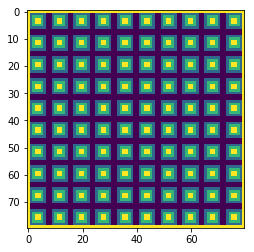

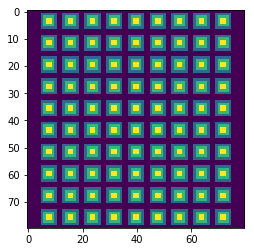

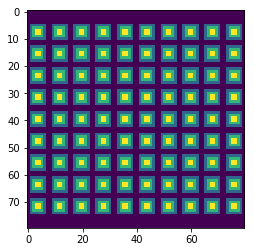

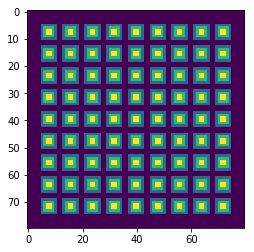

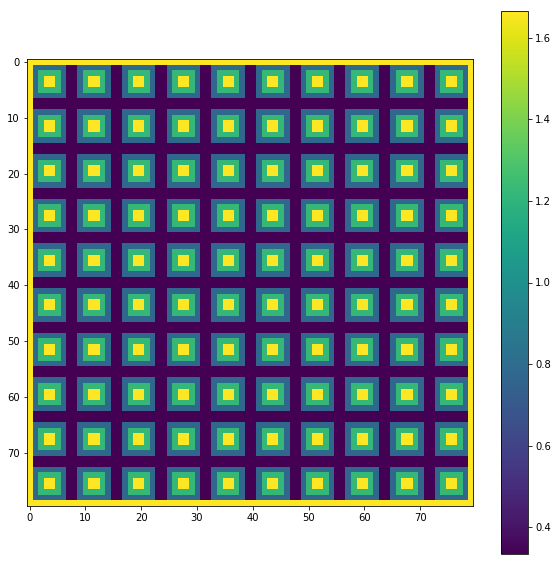

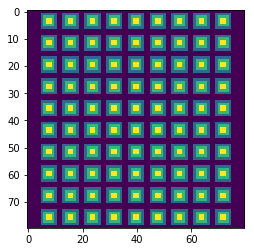

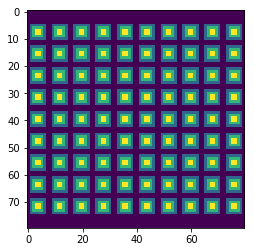

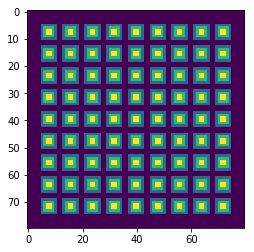

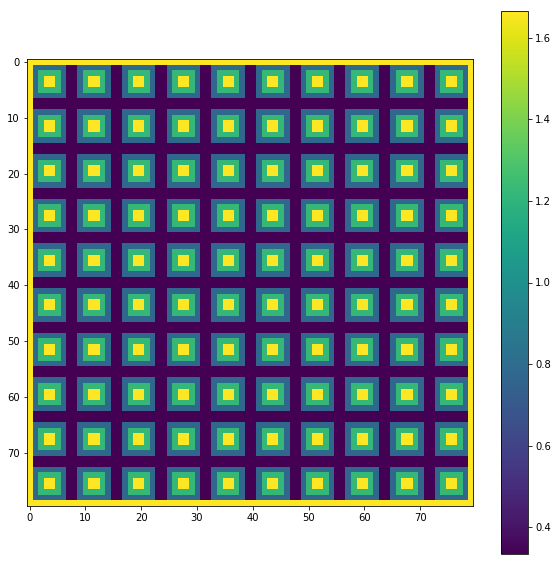

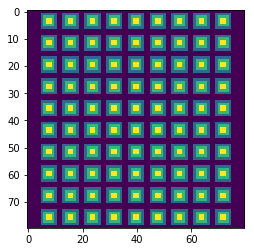

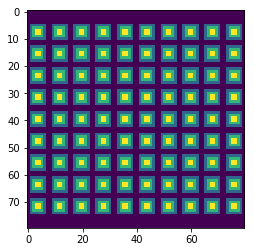

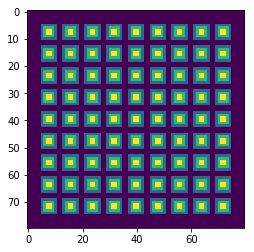

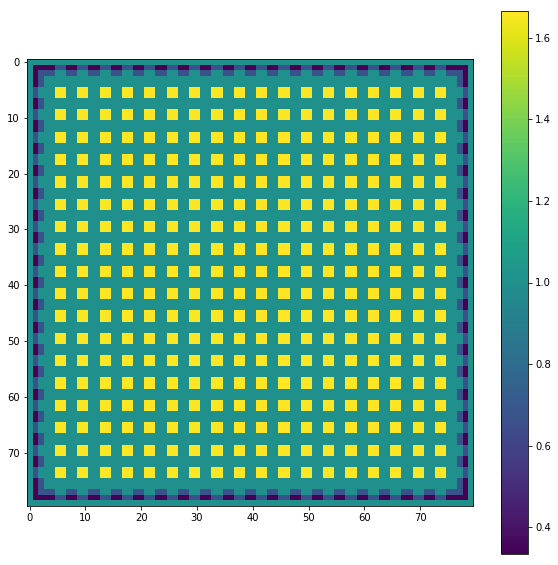

In [34]:
W1_four = pre_svd.combine_4xd(dims,row_cut,col_cut,dW_1,dW_rs1,dW_cs1,dW_rcs1)
W2_four = pre_svd.combine_4xd(dims,row_cut,col_cut,dW_2,dW_rs2,dW_cs2,dW_rcs2)
W3_four = pre_svd.combine_4xd(dims,row_cut,col_cut,dW_3,dW_rs3,dW_cs3,dW_rcs3)

In [ ]:
M1.play(gain=1,magnification=5)

In [35]:
# Visualize local correlation
def show_img(ax, img,vmin=None,vmax=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    im = ax.imshow(img,vmin=vmin,vmax=vmax,cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    if np.abs(img.min())< 1:
        format_tile ='%.2f'
    else:
        format_tile ='%5d'
    plt.colorbar(im, cax=cax,orientation='horizontal',
                 spacing='uniform',format=format_tile)#'%.2f') # %3d for 2p

In [36]:
np.savez('baylor_3D_dx4_.npz',W1_four=W1_four,W2_four=W2_four,W3_four=W3_four)

min -4.798074722290039,  max 27.030746459960938
0.013707222


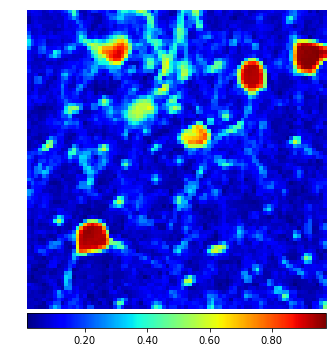

min -4.0830295588468495,  max 25.93940013855359
0.079534665


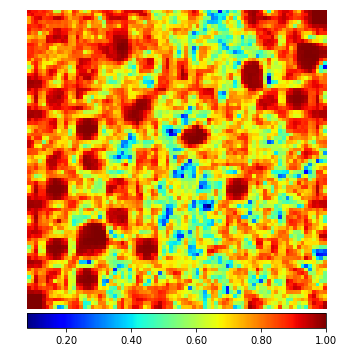

min -6.720598897612268,  max 11.481985230984769
-0.023345344


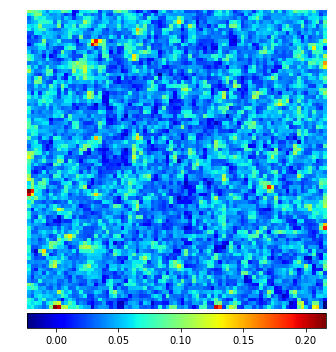

In [50]:
import matplotlib.pyplot as plt

cn_see = [W3.reshape(dims,order='F'),W3_four,W3.reshape(dims,order='F')-W3_four]#[M,Yd_,M-Yd_]
#cn_see = [W3.reshape(dims,order='F'),dW_3r,W3.reshape(dims,order='F')-dW_3r]#[M,Yd_,M-Yd_]
for array in cn_see:
    # LOCAL CORRELATION
    if not type(array)==cm.base.movies.movie:
        Cn_pre = cm.movie(array.transpose([2,0,1]))
    else:
        Cn_pre = array.transpose([2,0,1])
    #Cn = Cn_pre.local_correlations(swap_dim=False)
    Cn, _ = cm.summary_images.correlation_pnr(array, gSig=None, center_psf=False) # 10 no ds
    print ('min {},  max {}'.format(array.min(),array.max()))
    # VARIANCE
    #Cn = array.var(2)/array.shape[2]
    # PNR
    #_, Cn = cm.summary_images.correlation_pnr(array, gSig=None, center_psf=False)
    print(Cn.min())
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes()
    ax.axis('off')
    show_img(ax, Cn)#,vmin=Cn.min(),vmax=Cn.max())
    #fig = plt.gcf()
    #fig.set_size_inches(40, 8)
    plt.tight_layout()
    plt.show()

In [54]:
M1 = cm.movie(np.asarray(W1.reshape(dims,order='F')).transpose([2,0,1]))#[:,30:60,30:60]
M2 = cm.movie(np.asarray(W2.reshape(dims,order='F')).transpose([2,0,1]))#[:,30:60,30:60]
M3 = cm.movie(np.asarray(W3.reshape(dims,order='F')).transpose([2,0,1]))#[:,30:60,30:60]

M4 = cm.movie(np.asarray(dW_1r).transpose([2,0,1]))#[:,30:60,30:60]
M5 = cm.movie(np.asarray(dW_2r).transpose([2,0,1]))#[:,30:60,30:60]
M6 = cm.movie(np.asarray(dW_3r).transpose([2,0,1]))#[:,30:60,30:60]

M7  = M1 - M4
M8  = M2 - M5
M9  = M3 - M6

if True:
    M1 = M1-M1.min(0,keepdims=True)
    M2 = M2-M2.min(0,keepdims=True)
    M3 = M3-M3.min(0,keepdims=True)
    M4 = M4-M4.min(0,keepdims=True)
    M5 = M5-M5.min(0,keepdims=True)
    M6 = M6-M6.min(0,keepdims=True)
    M7 = M7-M7.min(0,keepdims=True)
    M8 = M8-M8.min(0,keepdims=True)
    M9 = M9-M9.min(0,keepdims=True)

if False:
    max_ = max(list(map(np.amax,[M1,M2,M3])))[()]
    M1 = M1*max_/M1.max()
    M2 = M2*max_/M2.max()
    M3 = M3*max_/M3.max()

cm.concatenate([
    cm.concatenate([M1,M4,M7],axis=2),
    cm.concatenate([M2,M5,M8],axis=2),
    cm.concatenate([M3,M6,M9],axis=2)],axis=1)[500:,:,:].play(gain=2,magnification=4)